## Super Mario Maker Dataset - Network Analysis

### 1. Prerequisites

Import required libraries.

In [1]:
!pip install surprise

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import os
import gc
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import model_selection
from surprise import NormalPredictor, SVD, KNNBasic, SVDpp
from surprise import Dataset
from surprise import Reader
import surprise
from surprise.model_selection import cross_validate, train_test_split
from surprise import accuracy
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
import networkx as nx
import math
import random as rand
import sys
import csv

Specify data files location.

In [2]:
data_path = '/Users/pj/Documents/671_Project/'

Read data of games played.

In [3]:
plays_df = pd.read_csv(data_path + 'plays.csv', sep="\t", usecols=['id', 'player'])
plays_df.columns = ['game', 'player']

In [4]:
plays_df.head()

,game,player
0,0000-0000-0353-3D35,darter60k
1,0000-0000-0353-3D35,davidchofis
2,0000-0000-0353-3D35,fabioviana
3,0000-0000-0353-3D35,gorigokky
4,0000-0000-0353-3D35,groebenzell


Add a column with value of 0 to start with indicating game is played but not cleared by the player.

In [5]:
plays_df['score'] = 0

Read data of games cleared data.

In [6]:
clears_df = pd.read_csv('/Users/pj/Documents/671_Project/clears.csv', sep='\t', usecols=['id', 'player'])
clears_df.columns = ['game', 'player']

In [7]:
clears_df.head()

,game,player
0,0000-0000-0353-3D35,darter60k
1,0000-0000-0353-3D35,davidchofis
2,0000-0000-0353-3D35,fabioviana
3,0000-0000-0353-3D35,groebenzell
4,0000-0000-0353-3D35,igatake0229


Add a column with value of 1 indicating that the game is cleared by the player.

In [8]:
clears_df['score'] = 1

Next we merge the 2 dataframes, so it now has information about games cleared as well as games played, but not cleared.

In [9]:
all_data = clears_df.merge(plays_df, how='outer', on=['game', 'player'])

Replace *NaN* values with $0$.

In [10]:
all_data.fillna(0, inplace=True)

Drop last column *score_y* as it contains only zeroes, all required information is now available in *score_x*. It is $0$ when the player has just played the game, but not cleared. It is $1$ when the player has cleared that game.

In [11]:
all_data.drop(columns='score_y', inplace=True)

Presently, $0$ and $1$ labels are segregated, lets shuffle the dataframe to distribute them.

In [12]:
all_data = all_data.sample(frac=1).reset_index(drop=True)

### 2. Exploratory Data Analysis.

Let us check some data attributes before building the recommendation system.

In [13]:
print('Total number of players : {}'.format(len(all_data['player'].value_counts())))
print('Total number of games   : {}'.format(len(all_data['game'].value_counts())))

Total number of players : 861465
Total number of games   : 115032


In [14]:
print('Number of games played and cleared     : {}'.format(len(all_data[all_data['score_x'] == 1])))
print('Number of games played but not cleared : {}'.format(len(all_data[all_data['score_x'] == 0])))

Number of games played and cleared     : 2051809
Number of games played but not cleared : 2036348


**Comment:** As we can observed from output of above cell, there is approximately $50:50$ split between game levels cleared and games only played.

### 3. Community detection system data preparation.

Note: I have tried to generate a vector representation for each user using the 'likes' data, however, creating a high dimensional vector for each user is very slow, and it might take few days to complete it for all data. So I had to abandon that approach. An alternative approach based on the SVD recommender system seems more practical. We have a $100$ dimensional vector representation for each user generated by the SVD algorithm. This vector can be used as input to clustering algorithm. However, since we have total $861465$ users, for Girvan-Newman algorithm we will need a $861465^2$ array to hold the edge weights/connectivity data, which throws Google Colab VM out of memory. So I have developed the model for $5000$ users. You can run it on your machine, by just changing the $max\_users$ parameter and see how many users the machine memory can handle.

In [15]:
max_users = 5000

In [16]:
reader = Reader(rating_scale=(0, 1))

Since clustering is an unsupervised machine learning problem, we do not need train/val/test split. So let's generate dataset based on all data

In [17]:
cluster_data    = Dataset.load_from_df(all_data[['player', 'game', 'score_x']], reader)
cluster_set, _  = surprise.model_selection.train_test_split(cluster_data, test_size=1e-9) # test size cannot be zero, so using a small value

Next, we obtain vector representations for players ($100$-dimensional), by using SVD algorithm.

In [18]:
cluster_svd = SVD(biased=False)

In [19]:
cluster_svd.fit(cluster_set)

In [20]:
users_v = cluster_svd.pu[:max_users]

### Baseline method: k-Means clustering.

Number of clusters: 1 	Labels: [0 0 0 ... 0 0 0]
Number of clusters: 3 	Labels: [0 0 1 ... 1 1 1]
Number of clusters: 5 	Labels: [4 2 1 ... 4 1 1]
Number of clusters: 7 	Labels: [3 3 3 ... 2 3 2]
Number of clusters: 9 	Labels: [6 0 8 ... 6 0 7]
Number of clusters: 11 	Labels: [4 6 7 ... 1 7 7]
Number of clusters: 13 	Labels: [ 8 11  4 ...  7  3  2]
Number of clusters: 15 	Labels: [13  5 13 ...  5  3  7]
Number of clusters: 17 	Labels: [ 9 12 13 ...  7 12 14]
Number of clusters: 19 	Labels: [ 6 17  1 ...  4 11 12]
Number of clusters: 21 	Labels: [16  7 12 ...  7  8 20]
Number of clusters: 23 	Labels: [18 16 12 ...  5  0  7]
Number of clusters: 25 	Labels: [16 18 19 ...  4 17 12]
Number of clusters: 27 	Labels: [12 24  1 ...  6  9  3]
Number of clusters: 29 	Labels: [20 23 10 ...  2 23 26]
Number of clusters: 31 	Labels: [11  6  8 ... 19  7 19]
Number of clusters: 33 	Labels: [ 8 21 14 ... 17 26  0]
Number of clusters: 35 	Labels: [ 3  3 19 ... 31 16 29]
Number of clusters: 37 	Labels: [

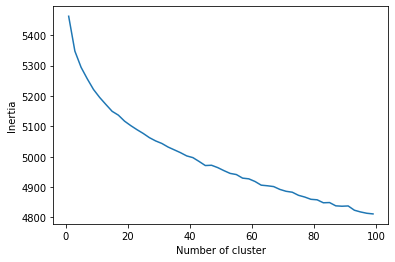

In [21]:
inertia = {}
for k in range(1, 100, 2):
    print('Number of clusters:', k, '\tLabels:', end=' ')
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(users_v)
    print(kmeans.labels_)
    inertia[k] = kmeans.inertia_ # Inertia: Sum of squared distances of samples to their closest cluster center
plt.figure()
plt.plot(list(inertia.keys()), list(inertia.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Inertia")
plt.show()

### Girvan-Newman algorithm based on "edge betweenness".

In [22]:
sim_scores = cosine_distances(users_v,users_v)

In [23]:
sim_scores.shape

(5000, 5000)

In [24]:
#node1_data[0]

NameError: name 'node1_data' is not defined

In [44]:
edge_data = pd.DataFrame(columns=['node1', 'node2', 'weight'])
indx = 0

for i in range(0, max_users):
  print(i)
  for j in range(i+1, max_users):
    if sim_scores[i, j] > 0.5:
      edge_data.loc[indx, :] = [i, j, sim_scores[i, j]]
      indx += 1

0
1
2
3
4
5
6
7
8


KeyboardInterrupt: 

In [43]:
edge_data.head()

,node1,node2,weight,"(0, 1, 2)"
0,NaN,NaN,NaN,4998.000000
1,NaN,NaN,NaN,4999.000000
2,NaN,NaN,NaN,0.988971


In [42]:
edge_data['node1'] = edge_data['node1'].astype('int32')
edge_data['node2'] = edge_data['node2'].astype('int32')

ValueError: cannot convert float NaN to integer

In [36]:
graph_file = 'edge_data.csv'

In [37]:
edge_data.to_csv(graph_file, sep='\t', header=False, index=False)

In [38]:
G = nx.Graph()
reader = csv.reader(open(graph_file), delimiter='\t')
for line in reader:
  if len(line) > 2:
    if float(line[2]) != 0.0:
      #line format: u,v,w
       G.add_edge(int(line[0]),int(line[1]),weight=float(line[2]))
    else:
      #line format: u,v
      G.add_edge(int(line[0]),int(line[1]),weight=1.0)

In [39]:
print('G nodes:', G.nodes())
print('G no of nodes:', G.number_of_nodes())

G nodes: []
G no of nodes: 0


In [0]:
n = G.number_of_nodes()
A = nx.adj_matrix(G)

In [55]:
m_ = 0.0    #the weighted version for number of edges
for i in range(0,n):
  for j in range(0,n):
     m_ += A[i,j]
m_ = m_/2.0

print("m:", m_)

m: 1122.0


In [0]:
#calculate the weighted degree for each node
Orig_deg = {}
deg_dict = {}
nodes = G.nodes()
n = len(nodes)  #len(A) ---> some ppl get issues when trying len() on sparse matrixes!
B = A.sum(axis = 1)
i = 0
for node_id in list(nodes):
  deg_dict[node_id] = B[i, 0]
  i += 1
Orig_deg = deg_dict

In [0]:
# This method keeps removing edges from Graph until one of the connected components of Graph splits into two
# compute the edge betweenness
def CmtyGirvanNewmanStep(G):
    print("Running CmtyGirvanNewmanStep method ...")
    init_ncomp = nx.number_connected_components(G)    #no of components
    ncomp = init_ncomp
    while ncomp <= init_ncomp:
        bw = nx.edge_betweenness_centrality(G, weight='weight')    #edge betweenness for G
        #find the edge with max centrality
        max_ = max(bw.values())
        #find the edge with the highest centrality and remove all of them if there is more than one!
        for k, v in bw.items():
            if float(v) == max_:
                G.remove_edge(k[0],k[1])    #remove the central edge
        ncomp = nx.number_connected_components(G)    #recalculate the no of components


# This method compute the modularity of current split
def _GirvanNewmanGetModularity(G, deg_, m_):
    New_A = nx.adj_matrix(G)
    New_deg = {}
    New_deg = UpdateDeg(New_A, G.nodes())
    #Let's compute the Q
    comps = nx.connected_components(G)    #list of components    
    print('No of communities in decomposed G:', nx.number_connected_components(G))
    Mod = 0    #Modularity of a given partitionning
    for c in comps:
        EWC = 0    #no of edges within a community
        RE = 0    #no of random edges
        for u in c:
            EWC += New_deg[u]
            RE += deg_[u]        #count the probability of a random edge
        Mod += ( float(EWC) - float(RE*RE)/float(2*m_) )
    Mod = Mod/float(2*m_)
    print("Modularity:", Mod)
    return Mod

def UpdateDeg(A, nodes):
    deg_dict = {}
    n = len(nodes)  #len(A) ---> some ppl get issues when trying len() on sparse matrixes!
    B = A.sum(axis = 1)
    i = 0
    for node_id in list(nodes):
        deg_dict[node_id] = B[i, 0]
        i += 1
    return deg_dict

In [58]:
#let's find the best split of the graph
BestQ = 0.0
Q = 0.0
while True:    
    CmtyGirvanNewmanStep(G)
    Q = _GirvanNewmanGetModularity(G, Orig_deg, m_);
    print("Modularity of decomposed G:", Q)
    if Q > BestQ:
        BestQ = Q
        Bestcomps = list(nx.connected_components(G))    #Best Split
        print("Components:", Bestcomps)
    if G.number_of_edges() == 0:
       break
if BestQ > 0.0:
    print("Max modularity (Q):", BestQ)
    print("Graph communities:", Bestcomps)
else:
    print("Max modularity (Q):", BestQ)

Running CmtyGirvanNewmanStep method ...
No of communities in decomposed G: 23
Modularity: 0.09433792152414358
Modularity of decomposed G: 0.09433792152414358
Components: [{13825, 7170, 14851, 2563, 3598, 16, 17, 4629, 3095, 23105, 7709, 9760, 8226, 18467, 10274, 7207, 42, 17964, 19501, 6705, 11825, 4660, 5694, 16960, 5696, 65, 1091, 10817, 3653, 4677, 6215, 5703, 4673, 2628, 5711, 9807, 6226, 11347, 597, 7256, 2653, 15976, 13417, 15465, 20590, 110, 12911, 7790, 9842, 20083, 6258, 5239, 5242, 3706, 5755, 17021, 13439, 1153, 2690, 11907, 2692, 6282, 16012, 10895, 23183, 23698, 2710, 11927, 15000, 666, 9372, 4254, 16544, 163, 12456, 7849, 170, 8874, 7856, 9908, 14006, 9400, 11965, 16061, 2239, 13507, 4805, 4806, 3786, 13003, 7370, 4301, 2766, 11471, 5840, 8401, 20178, 6354, 8914, 213, 3286, 7895, 13014, 17626, 6875, 23772, 7903, 1247, 4321, 2279, 18157, 13550, 1775, 17652, 7413, 758, 8442, 20219, 12541, 1279, 1281, 8450, 5893, 2310, 268, 4366, 17167, 6416, 15122, 2834, 3862, 22295, 10009,

In [59]:
print("Max modularity (Q):", BestQ)
print("Number of communities:", len(Bestcomps))
print("Graph communities:", Bestcomps)


Max modularity (Q): 0.5099901976671402
Number of communities: 30
Graph communities: [{13825, 7170, 14851, 2563, 16, 3095, 7709, 8226, 18467, 7207, 42, 17964, 6705, 16960, 6215, 5703, 5711, 2653, 13417, 20590, 110, 12911, 9842, 5239, 5242, 3706, 5755, 13439, 1153, 6282, 10895, 23698, 11927, 666, 9372, 4254, 163, 170, 7856, 9908, 9400, 11965, 4805, 3786, 4301, 2766, 11471, 8401, 20178, 6354, 213, 13014, 7895, 6875, 23772, 7903, 1775, 758, 8442, 20219, 5893, 4366, 15122, 3862, 22295, 10009, 19738, 12591, 11059, 10058, 15179, 5452, 11599, 15193, 23897, 12127, 6496, 7524, 3435, 5998, 879, 881, 891, 5500, 4483, 12172, 18324, 20379, 6048, 12192, 21922, 4514, 5543, 11689, 9649, 1468, 8642, 12741, 13258, 16341, 10197, 7127, 10224, 19440}, {1281, 2690, 386, 2692, 11137, 17167, 17, 1937, 3473, 1427, 4629, 2710, 15000, 1945, 285, 1309, 16544, 1952, 10274, 16674, 12456, 1963, 2349, 13614, 19501, 9136, 2865, 11825, 4660, 3380, 14006, 7482, 10684, 16061, 18750, 2239, 65, 10817, 13507, 2628, 3653, 109